In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
from pathlib import Path
import pathlib
from datetime import datetime
from tqdm.notebook import tqdm
INPUT = '../../input/google-smartphone-decimeter-challenge/'
root = Path(INPUT)

In [2]:
EXP_NAME = str(Path().resolve()).split('/')[-1]

In [3]:
def init_logger(log_file='logger.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
    
today = datetime.now().strftime('%Y-%m-%d')
logger = init_logger(log_file=f'./{today}.log')
logger.info('Start Logging...')

Start Logging...


In [4]:
def ecef2lla(x, y, z):
    # x, y and z are scalars or vectors in meters
    x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
    y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
    z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

    a=6378137
    a_sq=a**2
    e = 8.181919084261345e-2
    e_sq = 6.69437999014e-3

    f = 1/298.257223563
    b = a*(1-f)

    # calculations:
    r = np.sqrt(x**2 + y**2)
    ep_sq  = (a**2-b**2)/b**2
    ee = (a**2-b**2)
    f = (54*b**2)*(z**2)
    g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
    c = (e_sq**2)*f*r**2/(g**3)
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
    p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
    q = np.sqrt(1 + 2*p*e_sq**2)
    r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
    u = np.sqrt((r - e_sq*r_0)**2 + z**2)
    v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
    z_0 = (b**2)*z/(a*v)
    h = u*(1 - b**2/(a*v))
    phi = np.arctan((z + ep_sq*z_0)/r)
    lambd = np.arctan2(y, x)

    return phi*180/np.pi, lambd*180/np.pi, h

def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
      np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [5]:
def make_gt(recal):
    if recal:
        p = pathlib.Path(INPUT)
        gt_files = list(p.glob('train/*/*/ground_truth.csv'))
        print('ground_truth.csv count : ', len(gt_files))

        gts = []
        for gt_file in tqdm(gt_files):
            gts.append(pd.read_csv(gt_file))
        ground_truth = pd.concat(gts)
        ground_truth.to_csv(root / 'gt.csv',index=False)
    else:
        ground_truth = pd.read_csv(root / 'gt.csv')
    return ground_truth
    
gt = make_gt(recal=True)

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

In [6]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score_df(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', "latDeg_gt", "lngDeg_gt"]], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='left')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    return df

def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby(['collectionName', 'phoneName'])['err'].agg([percentile50, percentile95]).reset_index()
    res['score'] = (res['percentile50'] + res['percentile95']) / 2 
    return res

In [7]:
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'Raw', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [8]:
def sort_epoch(input_df):
    df_list = []
    for (collectionName, phoneName), df in input_df.groupby(["collectionName", "phoneName"]):
        df = df.sort_values("millisSinceGpsEpoch")
        df_list.append(df)
    output_df = pd.concat(df_list).reset_index(drop=True)
    return output_df

In [9]:
# apply tips1
# _derivedのmillisSinceGpsEpochが次のepoch(rawの)を示しているので元に戻す
def apply_tips1(raw_df, derived_df):
    # Create a new column in df_raw that corresponds to derivedの['millisSinceGpsEpoch']
    raw_df['millisSinceGpsEpoch'] = np.floor((raw_df['TimeNanos'] - raw_df['FullBiasNanos']) / 1000000.0).astype(int)
        
    # Change each value in df_derived['MillisSinceGpsEpoch'] to be the prior epoch.
    raw_timestamps = raw_df['millisSinceGpsEpoch'].unique()
    derived_timestamps = derived_df['millisSinceGpsEpoch'].unique()

    # The timestamps in derived are one epoch ahead. We need to map each epoch
    # in derived to the prior one (in Raw).
    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    derived_df['millisSinceGpsEpoch'] = np.array(list(map(lambda v: from_t_to_fix_derived[v], derived_df['millisSinceGpsEpoch'])))
    return derived_df

# apply tips5
# derivedの重複している行を削除
def apply_tips5(derived_df):
    delta_millis = derived_df['millisSinceGpsEpoch'] - derived_df['receivedSvTimeInGpsNanos'] / 1e6
    where_good_signals = (delta_millis > 0) & (delta_millis < 300)
    return derived_df[where_good_signals]

In [10]:
output_dir = f'baseline_{EXP_NAME}/'
os.makedirs(output_dir, exist_ok=True)

In [11]:
base_train = pd.read_csv(root/ 'baseline_locations_train_with_speed.csv')
train_use_col = base_train.columns
# base_train.loc[:,['px','py','pz']] = 0
base_train.head()

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,pred_speedMps
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0.170657
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,-0.090300
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0.050574
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,-0.007225
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0.051520


In [12]:
# kwargsはdict
def distance(x, **kwargs):
    # weight = kwargs["uncertaintyWeight"]
    weight = np.array(kwargs["uncertaintyWeight"])
    prm = kwargs["correctedPrM"]
    
    satx = kwargs['xSatPosMRotated'] - x[0]
    saty = kwargs['ySatPosMRotated'] - x[1]
    satz = kwargs['zSatPosMRotated'] - x[2]
    d = weight * (np.sqrt((satx**2 + saty**2 +satz**2)) + x[3] - prm)
    return d

In [49]:
all_derived_df = pd.DataFrame()
for (collection_name, phone_name), base_df in base_train.groupby(['collectionName','phoneName']):
    break

phase = base_df['phase'].unique()[0]
# Train df here only contains one collection and one measurement
path = f'../../input/derived_v1/{collection_name}_{phone_name}_derived.csv'
if os.path.exists(path):
    print("use satpos fixed file")
    derived_df = pd.read_csv(path)
else:
    derived_df = pd.read_csv(root / f"{phase}/{collection_name}/{phone_name}/{phone_name}_derived.csv")
    gnss_df = gnss_log_to_dataframes(str(root / f"{phase}/{collection_name}/{phone_name}/{phone_name}_GnssLog.txt"))
    raw_df = gnss_df['Raw']
    derived_df = apply_tips1(raw_df, derived_df)
    derived_df = apply_tips5(derived_df)       

derived_df = derived_df.sort_values('millisSinceGpsEpoch')

# pseudorangeの修正
derived_df['correctedPrM'] = derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)


# 伝播時間=擬似距離/光速
# 受信時刻と送信時刻の差分となる
light_speed = 299_792_458
derived_df['transmissionTimeSeconds'] = derived_df['correctedPrM'] / light_speed

# Compute true sat positions at arrival time
# 到着までに衛星位置が移動しているのでこれを補正
omega_e = 7.2921151467e-5
derived_df['xSatPosMRotated'] = \
    np.cos(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['xSatPosM'] \
    + np.sin(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['ySatPosM']

derived_df['ySatPosMRotated'] = \
    - np.sin(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['xSatPosM'] \
    + np.cos(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['ySatPosM']

derived_df['zSatPosMRotated'] = derived_df['zSatPosM']

# derived_df = derived_df[derived_df["rawPrUncM"]<30]
# derived_df['uncertaintyWeight'] = 1 / derived_df['rawPrUncM']
derived_df['uncertaintyWeight'] = 1/derived_df['rawPrUncM'].apply(lambda x:x**2 + 3*x)

output_df = pd.DataFrame()
x_list = []
y_list = []
z_list = []
epoch_list = []
for epoch, df in derived_df.groupby('millisSinceGpsEpoch'): 

    # Corrected pseudorange according to data instructions
    # Time it took for signal to travel
    # Start point for the optimiser
    # N = len([i for i in df["signalType"].unique() if i != "GPS_L1"])
    # df = df[df['signalType'].isin(['GPS_L1', 'GPS_L5','GAL_E1', 'GAL_E5A'])]
    df = df[df['signalType'].isin(['GPS_L1', 'GPS_L5','GAL_E1', 'GAL_E5A', 'QZS_J1', 'QZS_J5'])]

    # 最小2乗法による座標の推定
    x0 = [0]*4
    opt_res = opt.least_squares(distance, x0, kwargs=df.to_dict(orient="list"))

    # Optimiser yields a position in the ECEF coordinates
    opt_res_pos = opt_res.x
    d = distance(opt_res_pos, **df.to_dict(orient="list"))



use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos

<AxesSubplot:>

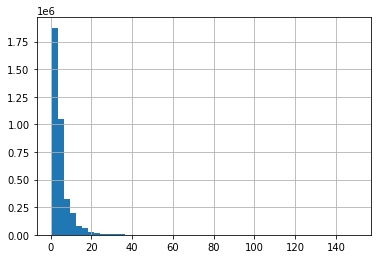

In [50]:
all_derived_df["rawPrUncM"].hist(bins=50)

In [51]:
all_derived_df["rawPrUncM"].quantile(0.90)

10.193

In [92]:
def estimate_position_by_derived(args):
    (collection_name, phone_name), base_df = args
    phase = base_df['phase'].unique()[0]
    # Train df here only contains one collection and one measurement
    path = f'../../input/derived_v1/{collection_name}_{phone_name}_derived.csv'
    if os.path.exists(path):
        print("use satpos fixed file")
        derived_df = pd.read_csv(path)
    else:
        derived_df = pd.read_csv(root / f"{phase}/{collection_name}/{phone_name}/{phone_name}_derived.csv")
        gnss_df = gnss_log_to_dataframes(str(root / f"{phase}/{collection_name}/{phone_name}/{phone_name}_GnssLog.txt"))
        raw_df = gnss_df['Raw']
        derived_df = apply_tips1(raw_df, derived_df)
        derived_df = apply_tips5(derived_df)       

    derived_df = derived_df.sort_values('millisSinceGpsEpoch')

    # pseudorangeの修正
    derived_df['correctedPrM'] = derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)


    # 伝播時間=擬似距離/光速
    # 受信時刻と送信時刻の差分となる
    light_speed = 299_792_458
    derived_df['transmissionTimeSeconds'] = derived_df['correctedPrM'] / light_speed

    # Compute true sat positions at arrival time
    # 到着までに衛星位置が移動しているのでこれを補正
    omega_e = 7.2921151467e-5
    derived_df['xSatPosMRotated'] = \
        np.cos(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['xSatPosM'] \
        + np.sin(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['ySatPosM']

    derived_df['ySatPosMRotated'] = \
        - np.sin(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['xSatPosM'] \
        + np.cos(omega_e * derived_df['transmissionTimeSeconds']) * derived_df['ySatPosM']

    derived_df['zSatPosMRotated'] = derived_df['zSatPosM']

    

    # derived_df = derived_df[derived_df["rawPrUncM"]<30]
    # derived_df['uncertaintyWeight'] = 1 / derived_df['rawPrUncM']
    derived_df['uncertaintyWeight'] = 1/derived_df['rawPrUncM'].apply(lambda x:x**2 + 3*x)

    output_df = pd.DataFrame()
    x_list = []
    y_list = []
    z_list = []
    epoch_list = []
    for epoch, df in derived_df.groupby('millisSinceGpsEpoch'): 

        # Corrected pseudorange according to data instructions
        # Time it took for signal to travel
        # Start point for the optimiser
        # N = len([i for i in df["signalType"].unique() if i != "GPS_L1"])
        # df = df[df['signalType'].isin(['GPS_L1', 'GPS_L5','GAL_E1', 'GAL_E5A'])]
        df = df[df['signalType'].isin(['GPS_L1', 'GPS_L5','GAL_E1', 'GAL_E5A', 'QZS_J1', 'QZS_J5'])]

        # 最小2乗法による座標の推定
        x0 = [0]*4
        opt_res = opt.least_squares(distance, x0, kwargs=df.to_dict(orient="list"))

        # Optimiser yields a position in the ECEF coordinates
        opt_res_pos = opt_res.x
        d = distance(opt_res_pos, **df.to_dict(orient="list"))

        # ECEF position to lat/long
        wls_estimated_pos = ecef2lla(*opt_res_pos[:3])
        wls_estimated_pos = np.squeeze(wls_estimated_pos)
        x_list.append(wls_estimated_pos[0])
        y_list.append(wls_estimated_pos[1])
        z_list.append(wls_estimated_pos[2])
        epoch_list.append(epoch)
    
    output_df["latDeg"] = x_list
    output_df["lngDeg"] = y_list
    # output_df['heightAboveWgs84EllipsoidM'] = z_list
    output_df['millisSinceGpsEpoch'] = epoch_list
    output_df['collectionName'] = collection_name
    output_df['phoneName'] = phone_name

    output_df.to_csv(output_dir + f'{collection_name}_{phone_name}_derived.csv', index=False)
    return output_df

In [93]:
import multiprocessing

base_train['phase'] = 'train'
gr = base_train.groupby(['collectionName','phoneName'])
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(estimate_position_by_derived, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
all_derived_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).reset_index(drop=True)     

  0%|          | 0/73 [00:00<?, ?it/s]

use satpos fixed fileuse satpos fixed fileuse satpos fixed fileuse satpos fixed file



use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed file
use satpos fixed fileuse satpos fixed file

use satpos fixed file
use satpos fixed fileuse satpos fixed file
use satpos fixed fileuse satpos fixed file

use satpos fixed fileuse satpos fixed fileuse satpos fixed fileuse satpos fixed file
use satpos fixed file




use satpos fixed fileuse satpos fixed file

Loading ../../input/google-smartphone-decimeter-challenge/train/2020-06-11-US-MTV-1/Pixel4/Pixel4_GnssLog.txt
Loading ../../input/google-smartphone-decimeter-challenge/train/2020-06-11-US-MTV-1/Pixel4XL/Pixel4XL_GnssLog.txt
use satpos fixed file
use satpos fixed file
use satpos fixed file
Loading ../../input/google-smartphone-decimeter-challenge/train/2020-08-03-US-MTV-1/Mi8/Mi8_GnssLog.txt
Loading ../../input/google-smartphone-decimeter-challenge/train/2020-08-03-US-MTV-1/Pixel4/Pixel4_GnssLog.txt
Loading ../.

In [94]:
df_list = []
for (collection_name, phone_name), base_df in tqdm(base_train.groupby(['collectionName','phoneName'])):
    print(f"\n{collection_name} {phone_name}")
    base_df = base_df.sort_values('millisSinceGpsEpoch')
    target_gt = gt[(gt['collectionName']==collection_name)&(gt['phoneName']==phone_name)].sort_values('millisSinceGpsEpoch').reset_index(drop=True)
    
    derived_df = pd.read_csv(output_dir + f'{collection_name}_{phone_name}_derived.csv')
    derived_df = derived_df[~derived_df["millisSinceGpsEpoch"].duplicated()].sort_values("millisSinceGpsEpoch").reset_index(drop=True)
    derived_df = derived_df.rename(columns={"latDeg":"_latDeg", "lngDeg":"_lngDeg"})
    print(base_df.shape, target_gt.shape, derived_df.shape)
    base_score_df = get_train_score(base_df, target_gt)
    print("baseline:", base_score_df['score'].mean())

    derived_df = pd.merge_asof(base_df, derived_df[["millisSinceGpsEpoch", "_latDeg", "_lngDeg"]], on=["millisSinceGpsEpoch"], tolerance=10, direction='nearest')

    # replace if data is nan 
    derived_df.loc[derived_df["_latDeg"].isna(), "_latDeg"] = derived_df.loc[derived_df["_latDeg"].isna(), "latDeg"].values
    derived_df.loc[derived_df["_lngDeg"].isna(), "_lngDeg"] = derived_df.loc[derived_df["_lngDeg"].isna(), "lngDeg"].values

    derived_df = derived_df.drop(["latDeg", "lngDeg"], axis=1).rename(columns={"_latDeg":"latDeg","_lngDeg":"lngDeg"})
    _derived_df = get_train_score_df(derived_df, target_gt)
    df_list.append(derived_df)
    derived_score_df = get_train_score(derived_df, target_gt)
    print("derived:", derived_score_df['score'].mean())
base_train2 = pd.concat(df_list).reset_index(drop=True)

  0%|          | 0/73 [00:00<?, ?it/s]


2020-05-14-US-MTV-1 Pixel4
(1740, 9) (1740, 11) (1738, 5)
baseline: 2.100601745976844
derived: 2.0732616199441782

2020-05-14-US-MTV-1 Pixel4XLModded
(1746, 9) (1746, 11) (1744, 5)
baseline: 3.169948400933192
derived: 3.542500779704035

2020-05-14-US-MTV-2 Pixel4
(1770, 9) (1770, 11) (1768, 5)
baseline: 2.0838364333971855
derived: 2.0168315392066902

2020-05-14-US-MTV-2 Pixel4XLModded
(577, 9) (577, 11) (570, 5)
baseline: 7.362608642825408
derived: 6.7840011191309655

2020-05-21-US-MTV-1 Pixel4
(2031, 9) (2031, 11) (1958, 5)
baseline: 3.2407210547287955
derived: 3.0779085376733866

2020-05-21-US-MTV-2 Pixel4
(1965, 9) (1965, 11) (1963, 5)
baseline: 2.1194285544204288
derived: 2.0748577715257435

2020-05-21-US-MTV-2 Pixel4XL
(1794, 9) (1794, 11) (1742, 5)
baseline: 2.27732233777214
derived: 2.4070582134571

2020-05-29-US-MTV-1 Pixel4
(1913, 9) (1913, 11) (1911, 5)
baseline: 3.669069401945867
derived: 3.7754503635455063

2020-05-29-US-MTV-1 Pixel4XL
(1912, 9) (1912, 11) (1910, 5)
baseli

In [95]:
# baseline
base_train = sort_epoch(base_train)
score_df = get_train_score(base_train, gt)
base_score= score_df['score'].mean()
logger.info(f"baseline:{base_score}")

baseline:5.287970649047861


In [96]:
# reproduce
base_train2 = sort_epoch(base_train2)
score_df2 = get_train_score(base_train2, gt)
corrected_base_score = score_df2['score'].mean()
logger.info(f"corrected baseline:{corrected_base_score}")

corrected baseline:5.291997305417698


20m: 5.92.  
10m: 5.884    
8m: 5.876.   
7m: 5.871.   
6m: 5.8791. 

weightをx**2+3x: 5.767404991624924  
衛星を絞る: 5.579685483765087  
両方: 5.29163

In [68]:
# 30m以上baselineとずれているもの
idx = calc_haversine(base_train2["latDeg"], base_train2["lngDeg"],base_train["latDeg"],base_train["lngDeg"]) > 30
base_train2.loc[idx, "latDeg"] = base_train.loc[idx, "latDeg"].values
base_train2.loc[idx, "lngDeg"] = base_train.loc[idx, "lngDeg"].values

In [69]:
score_df2 = get_train_score(base_train2, gt)
corrected_base_score = score_df2['score'].mean()
logger.info(f"corrected baseline:{corrected_base_score}")

corrected baseline:5.217331100551898


In [70]:
score_df2.groupby('phoneName').mean().sort_values("score", ascending=False).style.bar(subset=['percentile50', 'percentile95', 'score'], color=['teal'])

,percentile50,percentile95,score
phoneName,,,
SamsungS20Ultra,4.602661,18.012561,11.307611
Pixel4,2.357467,9.107985,5.732726
Pixel5,3.002284,7.493041,5.247662
Pixel4XL,2.023444,5.469150,3.746297
Pixel4Modded,2.186674,5.160658,3.673666
Pixel4XLModded,1.954326,5.222359,3.588343
Mi8,1.849025,4.524631,3.186828


In [74]:
base_train2[train_use_col].to_csv(f"baseline_locations_train_{EXP_NAME}.csv", index=False)

In [75]:
mean_df = base_train.copy()
mean_df["latDeg"] = (base_train["latDeg"]*0.4 + base_train2["latDeg"]*0.6)
mean_df["lngDeg"] = (base_train["lngDeg"]*0.4 + base_train2["lngDeg"]*0.6)
mean_score_df = get_train_score(mean_df, gt)
print("mean baseline:", mean_score_df['score'].mean())
# mean_df.to_csv(f"baseline_locations_train_fixed_{EXP_NAME}.csv", index=False)

mean baseline: 5.000040326544882


In [76]:
base_test = pd.read_csv(root/ 'baseline_locations_test_with_speed.csv')
test_use_col = base_test.columns
# base_test.loc[:,['px','py','pz']] = 0
base_test.head()

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,pred_speedMps
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Pixel4,-0.000374
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416646,-122.082040,-31.76,2020-05-15-US-MTV-1_Pixel4,0.006241
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416652,-122.082039,-31.65,2020-05-15-US-MTV-1_Pixel4,0.015441
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416607,-122.082063,-31.52,2020-05-15-US-MTV-1_Pixel4,0.035798
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416609,-122.082073,-28.95,2020-05-15-US-MTV-1_Pixel4,-0.033386


In [77]:
import multiprocessing
base_test['phase'] = 'test'
gr = base_test.groupby(['collectionName','phoneName'])
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(estimate_position_by_derived, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
all_derived_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).reset_index(drop=True)     

use satpos fixed file
use satpos fixed fileuse satpos fixed file

use satpos fixed file

  0%|          | 0/48 [00:00<?, ?it/s]

use satpos fixed file

use satpos fixed file
use satpos fixed file
use satpos fixed fileuse satpos fixed file

use satpos fixed file
use satpos fixed file
use satpos fixed fileuse satpos fixed fileuse satpos fixed file


use satpos fixed fileuse satpos fixed fileuse satpos fixed file


use satpos fixed file
Loading ../../input/google-smartphone-decimeter-challenge/test/2020-08-03-US-MTV-2/Mi8/Mi8_GnssLog.txt
Loading ../../input/google-smartphone-decimeter-challenge/test/2020-08-03-US-MTV-2/Pixel4XL/Pixel4XL_GnssLog.txt
Loading ../../input/google-smartphone-decimeter-challenge/test/2020-08-03-US-MTV-2/Pixel4/Pixel4_GnssLog.txt
Loading ../../input/google-smartphone-decimeter-challenge/test/2020-06-10-US-MTV-2/Pixel4/Pixel4_GnssLog.txtLoading ../../input/google-smartphone-decimeter-challenge/test/2020-06-10-US-MTV-2/Pixel4XL/Pixel4XL_GnssLog.txtLoading ../../input/google-smartphone-decimeter-challenge/test/2020-06-10-US-MTV-2/Pixel4XLModded/Pixel4XLModded_GnssLog.txt


use satpos fixed fi

In [79]:
df_list = []
for (collection_name, phone_name), base_df in tqdm(base_test.groupby(['collectionName','phoneName'])):

    print(f"\n{collection_name} {phone_name}")
    base_df = base_df.sort_values('millisSinceGpsEpoch')

    derived_df = pd.read_csv(output_dir + f'{collection_name}_{phone_name}_derived.csv')
    derived_df = derived_df[~derived_df["millisSinceGpsEpoch"].duplicated()].sort_values("millisSinceGpsEpoch").reset_index(drop=True)
    derived_df = derived_df.rename(columns={"latDeg":"_latDeg", "lngDeg":"_lngDeg"})
    derived_df = pd.merge_asof(base_df, derived_df[["millisSinceGpsEpoch", "_latDeg", "_lngDeg"]], on=["millisSinceGpsEpoch"], tolerance=10, direction='nearest')

    # replace if data is nan 
    derived_df.loc[derived_df["_latDeg"].isna(), "_latDeg"] = derived_df.loc[derived_df["_latDeg"].isna(), "latDeg"].values
    derived_df.loc[derived_df["_lngDeg"].isna(), "_lngDeg"] = derived_df.loc[derived_df["_lngDeg"].isna(), "lngDeg"].values

    derived_df = derived_df.drop(["latDeg", "lngDeg"], axis=1).rename(columns={"_latDeg":"latDeg","_lngDeg":"lngDeg"})
    df_list.append(derived_df)
base_test2 = pd.concat(df_list).reset_index(drop=True)

  0%|          | 0/48 [00:00<?, ?it/s]


2020-05-15-US-MTV-1 Pixel4

2020-05-15-US-MTV-1 Pixel4XL

2020-05-28-US-MTV-1 Pixel4

2020-05-28-US-MTV-1 Pixel4XL

2020-05-28-US-MTV-2 Pixel4

2020-05-28-US-MTV-2 Pixel4XL

2020-05-28-US-MTV-2 Pixel4XLModded

2020-06-04-US-MTV-2 Pixel4

2020-06-04-US-MTV-2 Pixel4XL

2020-06-04-US-MTV-2 Pixel4XLModded

2020-06-10-US-MTV-1 Pixel4

2020-06-10-US-MTV-1 Pixel4XL

2020-06-10-US-MTV-1 Pixel4XLModded

2020-06-10-US-MTV-2 Pixel4

2020-06-10-US-MTV-2 Pixel4XL

2020-06-10-US-MTV-2 Pixel4XLModded

2020-08-03-US-MTV-2 Mi8

2020-08-03-US-MTV-2 Pixel4

2020-08-03-US-MTV-2 Pixel4XL

2020-08-13-US-MTV-1 Mi8

2020-08-13-US-MTV-1 Pixel4

2021-03-16-US-MTV-2 Pixel4Modded

2021-03-16-US-MTV-2 SamsungS20Ultra

2021-03-16-US-RWC-2 Pixel4XL

2021-03-16-US-RWC-2 Pixel5

2021-03-16-US-RWC-2 SamsungS20Ultra

2021-03-25-US-PAO-1 Mi8

2021-03-25-US-PAO-1 Pixel4

2021-03-25-US-PAO-1 Pixel4Modded

2021-03-25-US-PAO-1 Pixel5

2021-03-25-US-PAO-1 SamsungS20Ultra

2021-04-02-US-SJC-1 Pixel4

2021-04-02-US-SJC-1 Pixel

In [80]:
# 30m以上baselineとずれているもの
idx = calc_haversine(base_test2["latDeg"], base_test2["lngDeg"],base_test["latDeg"],base_test["lngDeg"]) > 30
base_test2.loc[idx, "latDeg"] = base_test.loc[idx, "latDeg"].values
base_test2.loc[idx, "lngDeg"] = base_test.loc[idx, "lngDeg"].values

In [81]:
base_test2[test_use_col]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,pred_speedMps
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416625,-122.082052,-30.69,2020-05-15-US-MTV-1_Pixel4,-0.000374
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416647,-122.082043,-31.76,2020-05-15-US-MTV-1_Pixel4,0.006241
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416656,-122.082039,-31.65,2020-05-15-US-MTV-1_Pixel4,0.015441
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416622,-122.082060,-31.52,2020-05-15-US-MTV-1_Pixel4,0.035798
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416620,-122.082070,-28.95,2020-05-15-US-MTV-1_Pixel4,-0.033386
...,...,...,...,...,...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000,37.334506,-121.899405,-8.39,2021-04-29-US-SJC-3_SamsungS20Ultra,0.004456
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000,37.334511,-121.899407,-7.36,2021-04-29-US-SJC-3_SamsungS20Ultra,0.025227
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000,37.334525,-121.899391,-4.08,2021-04-29-US-SJC-3_SamsungS20Ultra,0.010388
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000,37.334511,-121.899397,-5.70,2021-04-29-US-SJC-3_SamsungS20Ultra,-0.103886


In [82]:
base_test2[test_use_col].to_csv(f"baseline_locations_test_{EXP_NAME}.csv", index=False)